# Daily Sunshine App NLP Model

## Objective of this Notebook
To create a NLP Model that classifies a given piece of plaintext into two categories, Good or Bad. The output of the model will be presented as a floating point numeral. This numeral will help us interpret the decision.

## Notebook Plan

- Multiple models will be created for each of the following datasets as training input
  - [IMDb Movie Reviews Dataset](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)
  - [Financial Phrase Bank Dataset](https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news)
  - [Positive and Negative Word List](https://www.kaggle.com/datasets/mukulkirti/positive-and-negative-word-listrar)
  - [News Sentiment Dataset](https://www.kaggle.com/datasets/hoshi7/news-sentiment-dataset)

- All the above models will be tested on 
  - New Data points from the newsapi.org API
  - ["All the News" Dataset](https://www.kaggle.com/datasets/snapcrack/all-the-news)
  - ["Million News Headlines" Dataset](https://www.kaggle.com/datasets/therohk/million-headlines)
  

In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.12.*"
!pip install -q tf-models-official==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 19.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 91.4 MB/s eta 0:00:00


In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
def build_classifier_model(preprocess, encoder):
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

## Evaluation Datasets

### "All the News" Dataset

In [4]:
!cp "/content/drive/MyDrive/Colab Notebooks/Daily Sunshine App/data/all_the_news.csv" "/content/all_the_news.csv"

In [5]:
atn_dataframe = pd.read_csv('all_the_news.csv', encoding = 'utf-8', encoding_errors = 'ignore')

In [6]:
atn_dataframe.drop(atn_dataframe.iloc[:, 3:], inplace=True, axis=1)
atn_dataframe.drop(atn_dataframe.iloc[:, :2], inplace=True, axis=1)
atn_dataframe

,title
0,House Republicans Fret About Winning Their Hea...
1,Rift Between Officers and Residents as Killing...
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ..."
3,"Among Deaths in 2016, a Heavy Toll in Pop Musi..."
4,Kim Jong-un Says North Korea Is Preparing to T...
...,...
49995,"Rex Tillerson Says Climate Change Is Real, but …"
49996,The Biggest Intelligence Questions Raised by t...
49997,Trump Announces Plan That Does Little to Resol...
49998,Dozens of For-Profit Colleges Could Soon Close


In [7]:
def atn_array(n = 10):
  return np.squeeze(atn_dataframe.sample(n=n).values)

In [8]:
atn_array(20)

array(['National Academies: Immigrants’ Integration Is Slowing - Breitbart',
       'Trump’s plan to jumpstart US manufacturing could backfire over a major flaw',
       'How to lower your stress before Election Day, according to a top psychologist',
       'Injured ’Punkin Chunkin’ producer disappointed show is off, faces long recovery',
       'Monica Crowley bows out amid plagiarism accusations, says she will not join Trump administration',
       'David Frum: There Will Be a ’Scorched Earth Period of Recrimination’ for Trump, Supporters - Breitbart',
       'GOP, you need to make friends with Democrats',
       'Ted Cruz: ’Will Always Be a Big Fan’ of Sarah Palin, Regardless of 2016 - Breitbart',
       'Joe Biden Fast Facts',
       'Donald Trump Invites Conservative Media to White House for Exclusive Briefing - Breitbart',
       'Saudi Teenager Demands Apple Introduce Hijab Emojis - Breitbart',
       'Glenn Beck, Call Your Office: Drudge Buries Ted Cruz in ’Holy Roller’ Avalanc

### Million News Headlines Dataset

In [9]:
!cp "/content/drive/MyDrive/Colab Notebooks/Daily Sunshine App/data/million_news_headlines.csv" "/content/million_news_headlines.csv"

In [10]:
mnh_dataframe = pd.read_csv('million_news_headlines.csv', encoding = 'utf-8', encoding_errors = 'ignore')
mnh_dataframe

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers
...,...,...
1244179,20211231,two aged care residents die as state records 2...
1244180,20211231,victoria records 5;919 new cases and seven deaths
1244181,20211231,wa delays adopting new close contact definition
1244182,20211231,western ringtail possums found badly dehydrate...


In [11]:
mnh_dataframe.drop(mnh_dataframe.iloc[:, 0:1], inplace=True, axis=1)
mnh_dataframe

,headline_text
0,aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation
2,a g calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise
4,air nz strike to affect australian travellers
...,...
1244179,two aged care residents die as state records 2...
1244180,victoria records 5;919 new cases and seven deaths
1244181,wa delays adopting new close contact definition
1244182,western ringtail possums found badly dehydrate...


In [12]:
def mnh_array(n = 10):
  return np.squeeze(mnh_dataframe.sample(n=n).values)

In [13]:
mnh_array(20)

array(['leveson raw', 'us plans for iraq under civilian rule may begin',
       'johnson thrives in ashes sledgefest',
       'north korea not even close to resuming us talks kerry',
       'leaders to study cultural camp idea',
       'fifteen taliban killed in attack on us base', 'tinytpe photo',
       'nrl weekly wrap with matthew elliott',
       'wa indigenous community stories film project',
       'blaze breaks out on lower eyre peninsula',
       'hewitt reaches newport final',
       'whitsundays politician accused of backflip over net fishing ban',
       'the drum thursday 2 december',
       'mother stepfather record sentence over swinging sex child abuse',
       'gatlin scorches to diamond league sprint double',
       'mosse returns to ride americain', 'moore offered scottish deal',
       'farmer uses drone after cyclone', 'wednesday weather',
       'hackett headlines with four gold at stake'], dtype=object)

In [14]:
# Fixed Dataset for comparing models

eval_data = np.concatenate([atn_array(100), mnh_array(100)], 0)

In [15]:
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

## Model I - IMDb Movie Review Dataset

### Downloading the Dataset

In [16]:
imdb_url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

imdb_dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', imdb_url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

imdb_dataset_dir = os.path.join(os.path.dirname(imdb_dataset), 'aclImdb')

imdb_train_dir = os.path.join(imdb_dataset_dir, 'train')

84125825/84125825 [==============================] - 8s 0us/step


In [17]:
# Remove unused folders to make it easier to load the data
imdb_remove_dir = os.path.join(imdb_train_dir, 'unsup')
shutil.rmtree(imdb_remove_dir)

### Split the Data into Training, Testing & Validation sets

In [18]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

imdb_raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

imdb_class_names = imdb_raw_train_ds.class_names
imdb_train_ds = imdb_raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

imdb_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

imdb_val_ds = imdb_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

imdb_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

imdb_test_ds = imdb_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


### Visualise the data

In [19]:
for text_batch, label_batch in imdb_train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({imdb_class_names[label]})\n')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)

Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as the

### Selecting a Model

In [20]:
#@title Choose a BERT model to fine-tune for IMDb Model

imdb_bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]


imdb_tfhub_handle_encoder = map_name_to_handle[imdb_bert_model_name]
imdb_tfhub_handle_preprocess = map_model_to_preprocess[imdb_bert_model_name]

print(f'BERT model selected           : {imdb_tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {imdb_tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


### Preprocessing Model

In [21]:
imdb_bert_preprocess_model = hub.KerasLayer(imdb_tfhub_handle_preprocess)

### Using the BERT Model

In [22]:
imdb_bert_model = hub.KerasLayer(imdb_tfhub_handle_encoder)

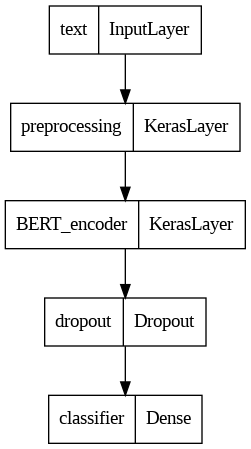

In [23]:
imdb_classifier_model = build_classifier_model(imdb_tfhub_handle_preprocess, imdb_tfhub_handle_encoder)
tf.keras.utils.plot_model(imdb_classifier_model)

In [24]:
imdb_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
imdb_metrics = tf.metrics.BinaryAccuracy()

imdb_epochs = 5
imdb_steps_per_epoch = tf.data.experimental.cardinality(imdb_train_ds).numpy()
imdb_num_train_steps = imdb_steps_per_epoch * imdb_epochs
imdb_num_warmup_steps = int(0.1*imdb_num_train_steps)

imdb_init_lr = 3e-5
imdb_optimizer = optimization.create_optimizer(init_lr=imdb_init_lr,
                                          num_train_steps=imdb_num_train_steps,
                                          num_warmup_steps=imdb_num_warmup_steps,
                                          optimizer_type='adamw')

In [25]:
imdb_classifier_model.compile(optimizer=imdb_optimizer,
                         loss=imdb_loss,
                         metrics=imdb_metrics)

imdb_history = imdb_classifier_model.fit(x=imdb_train_ds,
                               validation_data=imdb_val_ds,
                               epochs=imdb_epochs)

Epoch 1/5
625/625 [==============================] - 181s 272ms/step - loss: 0.4905 - binary_accuracy: 0.7380 - val_loss: 0.3733 - val_binary_accuracy: 0.8324
Epoch 2/5
625/625 [==============================] - 166s 266ms/step - loss: 0.3287 - binary_accuracy: 0.8526 - val_loss: 0.3750 - val_binary_accuracy: 0.8434
Epoch 3/5
625/625 [==============================] - 168s 269ms/step - loss: 0.2506 - binary_accuracy: 0.8937 - val_loss: 0.4061 - val_binary_accuracy: 0.8436
Epoch 4/5
625/625 [==============================] - 186s 298ms/step - loss: 0.1982 - binary_accuracy: 0.9197 - val_loss: 0.4556 - val_binary_accuracy: 0.8482
Epoch 5/5
625/625 [==============================] - 190s 304ms/step - loss: 0.1533 - binary_accuracy: 0.9421 - val_loss: 0.4904 - val_binary_accuracy: 0.8474


### Evaluating the Model

In [26]:
imdb_loss, imdb_accuracy = imdb_classifier_model.evaluate(imdb_test_ds)

print(f'Loss: {imdb_loss}')
print(f'Accuracy: {imdb_accuracy}')

782/782 [==============================] - 106s 135ms/step - loss: 0.4644 - binary_accuracy: 0.8545
Loss: 0.4643866717815399
Accuracy: 0.8545200228691101


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


Text(0, 0.5, 'Accuracy')

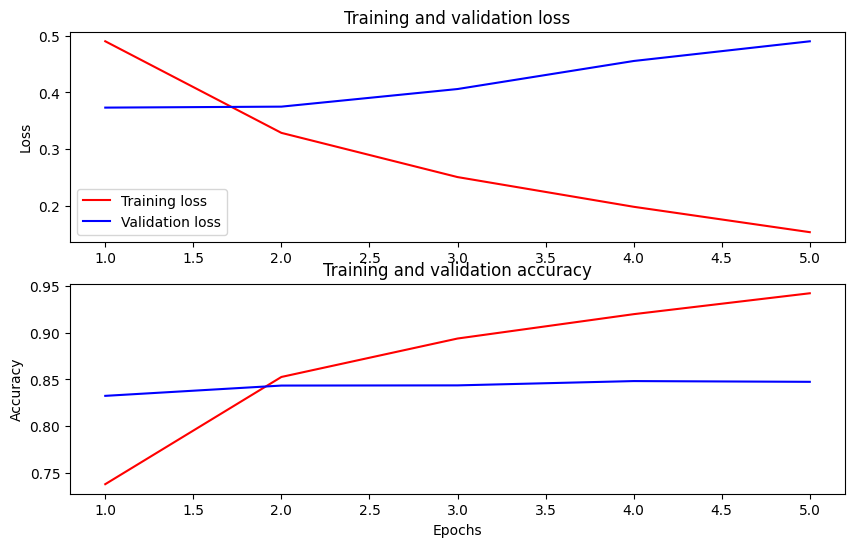

In [27]:
imdb_history_dict = imdb_history.history
print(imdb_history_dict.keys())

imdb_acc = imdb_history_dict['binary_accuracy']
imdb_val_acc = imdb_history_dict['val_binary_accuracy']
imdb_loss = imdb_history_dict['loss']
imdb_val_loss = imdb_history_dict['val_loss']

imdb_epochs = range(1, len(imdb_acc) + 1)
imdb_fig = plt.figure(figsize=(10, 6))
imdb_fig.tight_layout()

plt.subplot(2, 1, 1)

plt.plot(imdb_epochs, imdb_loss, 'r', label='Training loss')

plt.plot(imdb_epochs, imdb_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(imdb_epochs, imdb_acc, 'r', label='Training acc')
plt.plot(imdb_epochs, imdb_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

### Make Predictions

In [28]:
# imdb_eval_data = np.concatenate([atn_array(30), mnh_array(30)], 0)
imdb_df = pd.DataFrame(np.squeeze(imdb_classifier_model.predict(eval_data)))
imdb_df.insert(1, "Title", eval_data, True)
imdb_df

7/7 [==============================] - 2s 167ms/step


,0,Title
0,3.542113,More Women in Their 60s and 70s Are Having ‘Wa...
1,2.438075,"Harvard Political Review: To Understand Trump,..."
2,-0.465708,Justice Dept. Sues Michigan City After Mosque ...
3,3.762477,Introducing Myanmar’s ’Geek Girls’
4,3.165670,An Establishment Conservative’s Guide To The A...
...,...,...
195,-3.276024,phelps aiming to upstage thorpe
196,2.782313,kenbi mills
197,-0.555887,cracker of a cotton year
198,-0.844037,hannay to make origin debut


## Model II - Financial Phrase Bank Dataset

### Downloading the Dataset

In [29]:
!cp "/content/drive/MyDrive/Colab Notebooks/Daily Sunshine App/data/financial_phrase_bank.csv" "/content/financial_phrase_bank.csv"

In [30]:
fpb_dataframe = pd.read_csv('financial_phrase_bank.csv', encoding = 'utf-8', encoding_errors = 'ignore', names = ('Tone', 'Headline'))
fpb_dataframe = fpb_dataframe[fpb_dataframe['Tone'] != 'neutral']
fpb_dataframe

,Tone,Headline
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
5,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
6,positive,"For the last quarter of 2010 , Componenta 's n..."
...,...,...
4840,negative,HELSINKI Thomson Financial - Shares in Cargote...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


### Split the Data into Trinaing, Testing and Validation sets

In [31]:
!rm -rf financial_phrase_bank

In [32]:
fpb_dataset_dir = 'financial_phrase_bank'

os.mkdir(fpb_dataset_dir)

fpb_train_dir = os.path.join(fpb_dataset_dir, 'train')
fpb_test_dir = os.path.join(fpb_dataset_dir, 'test')

os.mkdir(fpb_train_dir)
os.mkdir(fpb_test_dir)

for path in [fpb_train_dir, fpb_test_dir]:
  os.mkdir(os.path.join(path, 'negative'))
  os.mkdir(os.path.join(path, 'positive'))


count_train = 1
count_test = 1

# Training Dataset
for ind in fpb_dataframe[int(.7*len(fpb_dataframe)):].index:
  with open(os.path.join(fpb_train_dir,  fpb_dataframe['Tone'][ind], str(count_train)+'.txt'), 'w') as file_obj:
    file_obj.write(fpb_dataframe['Headline'][ind])
  count_train +=1

# Testing Dataset
for ind in fpb_dataframe[:int(.3*len(fpb_dataframe))].index:
  with open(os.path.join(fpb_test_dir,  fpb_dataframe['Tone'][ind], str(count_test)+'.txt'), 'w') as file_obj:
    file_obj.write(fpb_dataframe['Headline'][ind])
  count_test +=1

In [33]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

fpb_raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    fpb_train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

fpb_class_names = fpb_raw_train_ds.class_names
fpb_train_ds = fpb_raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

fpb_val_ds = tf.keras.utils.text_dataset_from_directory(
    fpb_train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

fpb_val_ds = fpb_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

fpb_test_ds = tf.keras.utils.text_dataset_from_directory(
    fpb_test_dir,
    batch_size=batch_size)

fpb_test_ds = fpb_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 591 files belonging to 2 classes.
Using 473 files for training.
Found 591 files belonging to 2 classes.
Using 118 files for validation.
Found 590 files belonging to 2 classes.


### Selecting a Model

In [34]:
#@title Choose a BERT model to fine-tune for Financial Phrase Bank Model

fpb_bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]


fpb_tfhub_handle_encoder = map_name_to_handle[fpb_bert_model_name]
fpb_tfhub_handle_preprocess = map_model_to_preprocess[fpb_bert_model_name]

print(f'BERT model selected           : {fpb_tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {fpb_tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


### Using the BERT Model

In [35]:
fpb_bert_preprocess_model = hub.KerasLayer(fpb_tfhub_handle_preprocess)

In [36]:
fpb_bert_model = hub.KerasLayer(fpb_tfhub_handle_encoder)

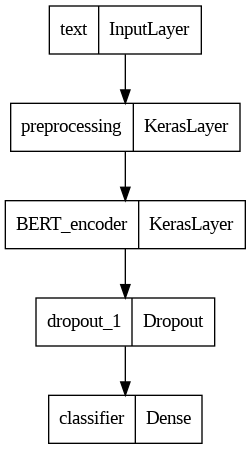

In [37]:
fpb_classifier_model = build_classifier_model(fpb_tfhub_handle_preprocess, fpb_tfhub_handle_encoder)
tf.keras.utils.plot_model(fpb_classifier_model)

In [38]:
fpb_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
fpb_metrics = tf.metrics.BinaryAccuracy()

fpb_epochs = 10
fpb_steps_per_epoch = tf.data.experimental.cardinality(fpb_train_ds).numpy()
fpb_num_train_steps = fpb_steps_per_epoch * fpb_epochs
fpb_num_warmup_steps = int(0.1*fpb_num_train_steps)

fpb_init_lr = 3e-5
fpb_optimizer = optimization.create_optimizer(init_lr=fpb_init_lr,
                                          num_train_steps=fpb_num_train_steps,
                                          num_warmup_steps=fpb_num_warmup_steps,
                                          optimizer_type='adamw')

In [39]:
fpb_classifier_model.compile(optimizer=fpb_optimizer,
                         loss=fpb_loss,
                         metrics=fpb_metrics)

fpb_history = fpb_classifier_model.fit(x=fpb_train_ds,
                               validation_data=fpb_val_ds,
                               epochs=fpb_epochs)

Epoch 1/10
15/15 [==============================] - 35s 1s/step - loss: 0.4667 - binary_accuracy: 0.8372 - val_loss: 0.3174 - val_binary_accuracy: 0.8814
Epoch 2/10
15/15 [==============================] - 14s 962ms/step - loss: 0.3378 - binary_accuracy: 0.8647 - val_loss: 0.2079 - val_binary_accuracy: 0.9407
Epoch 3/10
15/15 [==============================] - 14s 970ms/step - loss: 0.1934 - binary_accuracy: 0.9345 - val_loss: 0.1914 - val_binary_accuracy: 0.9492
Epoch 4/10
15/15 [==============================] - 15s 971ms/step - loss: 0.0851 - binary_accuracy: 0.9725 - val_loss: 0.2360 - val_binary_accuracy: 0.9576
Epoch 5/10
15/15 [==============================] - 15s 973ms/step - loss: 0.0230 - binary_accuracy: 0.9958 - val_loss: 0.3380 - val_binary_accuracy: 0.9322
Epoch 6/10
15/15 [==============================] - 15s 979ms/step - loss: 0.0261 - binary_accuracy: 0.9894 - val_loss: 0.2985 - val_binary_accuracy: 0.9576
Epoch 7/10
15/15 [==============================] - 15s 982ms

### Evaluate the Model

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


Text(0, 0.5, 'Accuracy')

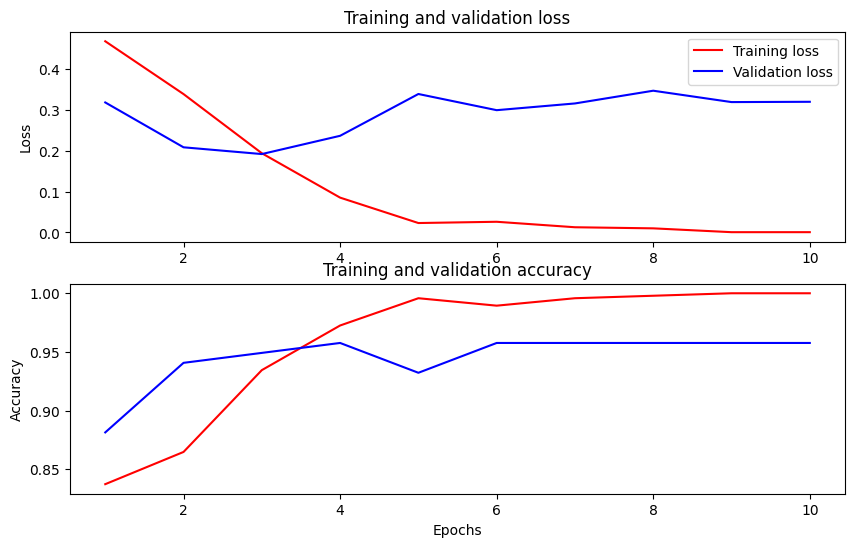

In [40]:
fpb_history_dict = fpb_history.history
print(fpb_history_dict.keys())

fpb_acc = fpb_history_dict['binary_accuracy']
fpb_val_acc = fpb_history_dict['val_binary_accuracy']
fpb_loss = fpb_history_dict['loss']
fpb_val_loss = fpb_history_dict['val_loss']

fpb_epochs = range(1, len(fpb_acc) + 1)
fpb_fig = plt.figure(figsize=(10, 6))
fpb_fig.tight_layout()

plt.subplot(2, 1, 1)

plt.plot(fpb_epochs, fpb_loss, 'r', label='Training loss')

plt.plot(fpb_epochs, fpb_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(fpb_epochs, fpb_acc, 'r', label='Training acc')
plt.plot(fpb_epochs, fpb_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

### Make Predictions

In [41]:
# fpb_eval_data = np.concatenate([atn_array(100), mnh_array(100)], 0)
fpb_df = pd.DataFrame(np.squeeze(fpb_classifier_model.predict(eval_data)), columns=['FPB Model'])
fpb_df.insert(1, "Title", eval_data, True)
fpb_df

7/7 [==============================] - 3s 310ms/step


,FPB Model,Title
0,-1.654533,More Women in Their 60s and 70s Are Having ‘Wa...
1,1.559295,"Harvard Political Review: To Understand Trump,..."
2,-3.411098,Justice Dept. Sues Michigan City After Mosque ...
3,6.470010,Introducing Myanmar’s ’Geek Girls’
4,4.444001,An Establishment Conservative’s Guide To The A...
...,...,...
195,3.688459,phelps aiming to upstage thorpe
196,3.759456,kenbi mills
197,-7.483743,cracker of a cotton year
198,6.614454,hannay to make origin debut


### Compare Predictions with the IMDb Model

In [42]:
overall_df = fpb_df
overall_df.insert(0, "IMDb Model", imdb_df[0])
overall_df

,IMDb Model,FPB Model,Title
0,3.542113,-1.654533,More Women in Their 60s and 70s Are Having ‘Wa...
1,2.438075,1.559295,"Harvard Political Review: To Understand Trump,..."
2,-0.465708,-3.411098,Justice Dept. Sues Michigan City After Mosque ...
3,3.762477,6.470010,Introducing Myanmar’s ’Geek Girls’
4,3.165670,4.444001,An Establishment Conservative’s Guide To The A...
...,...,...,...
195,-3.276024,3.688459,phelps aiming to upstage thorpe
196,2.782313,3.759456,kenbi mills
197,-0.555887,-7.483743,cracker of a cotton year
198,-0.844037,6.614454,hannay to make origin debut


## Model III - Positive and Negative Word List Dataset

### Downloading the Dataset

In [43]:
!cp "/content/drive/MyDrive/Colab Notebooks/Daily Sunshine App/data/positive_and_negative_word_list.csv" "/content/positive_and_negative_word_list.csv"

In [44]:
pnw_dataframe = pd.read_csv('positive_and_negative_word_list.csv', encoding = 'utf-8', encoding_errors = 'ignore', names = ('Negative', 'Positive'))
pnw_dataframe

,Negative,Positive
1,abnormal,able
2,abolish,abundance
3,abominable,accelerate
4,abominably,accept
5,abominate,acclaim
...,...,...
4716,zenana,NaN
4717,zephyr,NaN
4718,zero,NaN
4719,zol,NaN


### Split the data into Training, Testing and Validation Datasets

In [45]:
!rm -rf positive_and_negative_word_list

In [46]:
pnw_dataset_dir = 'positive_and_negative_word_list'

os.mkdir(pnw_dataset_dir)

pnw_train_dir = os.path.join(pnw_dataset_dir, 'train')
pnw_test_dir = os.path.join(pnw_dataset_dir, 'test')

os.mkdir(pnw_train_dir)
os.mkdir(pnw_test_dir)

for path in [pnw_train_dir, pnw_test_dir]:
  os.mkdir(os.path.join(path, 'negative'))
  os.mkdir(os.path.join(path, 'positive'))


count_train = 1
count_test = 1

# Training Dataset
for ind in pnw_dataframe[int(.6*len(pnw_dataframe)):].index:
  with open(os.path.join(pnw_train_dir,  'negative', str(count_train)+'.txt'), 'w') as file_obj:
    file_obj.write(pnw_dataframe['Negative'][ind])
  count_train +=1
  with open(os.path.join(pnw_train_dir,  'positive', str(count_train)+'.txt'), 'w') as file_obj:
    if (isinstance(pnw_dataframe['Positive'][ind], str)):
      file_obj.write(pnw_dataframe['Positive'][ind])
      count_train += 1

# Testing Dataset
for ind in pnw_dataframe[:int(.3*len(pnw_dataframe))].index:
  with open(os.path.join(pnw_test_dir,  'negative', str(count_test)+'.txt'), 'w') as file_obj:
    file_obj.write(pnw_dataframe['Negative'][ind])
  count_test +=1
  with open(os.path.join(pnw_test_dir,  'positive', str(count_test)+'.txt'), 'w') as file_obj:
    if (isinstance(pnw_dataframe['Positive'][ind], str)):
      file_obj.write(pnw_dataframe['Positive'][ind])
      count_test += 1

### Preprocess Data

In [47]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

pnw_raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    pnw_train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

pnw_class_names = pnw_raw_train_ds.class_names
pnw_train_ds = pnw_raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

pnw_val_ds = tf.keras.utils.text_dataset_from_directory(
    pnw_train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

pnw_val_ds = pnw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

pnw_test_ds = tf.keras.utils.text_dataset_from_directory(
    pnw_test_dir,
    batch_size=batch_size)

pnw_test_ds = pnw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3776 files belonging to 2 classes.
Using 3021 files for training.
Found 3776 files belonging to 2 classes.
Using 755 files for validation.
Found 2832 files belonging to 2 classes.


### Selecting a BERT Model

In [48]:
#@title Choose a BERT model to fine-tune for Positive and Negative Word List Model

pnw_bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]


pnw_tfhub_handle_encoder = map_name_to_handle[pnw_bert_model_name]
pnw_tfhub_handle_preprocess = map_model_to_preprocess[pnw_bert_model_name]

print(f'BERT model selected           : {pnw_tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {pnw_tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


In [49]:
pnw_bert_preprocess_model = hub.KerasLayer(pnw_tfhub_handle_preprocess)

In [50]:
pnw_bert_model = hub.KerasLayer(pnw_tfhub_handle_encoder)

### Using the BERT Model

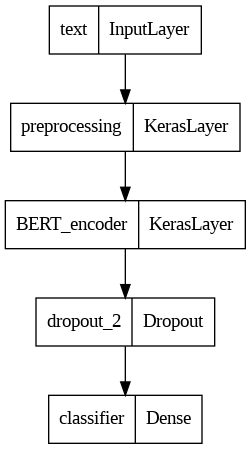

In [51]:
pnw_classifier_model = build_classifier_model(pnw_tfhub_handle_preprocess, pnw_tfhub_handle_encoder)
tf.keras.utils.plot_model(pnw_classifier_model)

In [52]:
pnw_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
pnw_metrics = tf.metrics.BinaryAccuracy()

pnw_epochs = 10
pnw_steps_per_epoch = tf.data.experimental.cardinality(pnw_train_ds).numpy()
pnw_num_train_steps = pnw_steps_per_epoch * pnw_epochs
pnw_num_warmup_steps = int(0.1*pnw_num_train_steps)

pnw_init_lr = 3e-5
pnw_optimizer = optimization.create_optimizer(init_lr=pnw_init_lr,
                                          num_train_steps=pnw_num_train_steps,
                                          num_warmup_steps=pnw_num_warmup_steps,
                                          optimizer_type='adamw')

In [53]:
pnw_classifier_model.compile(optimizer=pnw_optimizer,
                         loss=pnw_loss,
                         metrics=pnw_metrics)

pnw_history = pnw_classifier_model.fit(x=pnw_train_ds,
                               validation_data=pnw_val_ds,
                               epochs=pnw_epochs)

Epoch 1/10
95/95 [==============================] - 113s 994ms/step - loss: 0.6197 - binary_accuracy: 0.6197 - val_loss: 0.4979 - val_binary_accuracy: 0.7735
Epoch 2/10
95/95 [==============================] - 92s 970ms/step - loss: 0.4317 - binary_accuracy: 0.8004 - val_loss: 0.4933 - val_binary_accuracy: 0.8146
Epoch 3/10
95/95 [==============================] - 93s 979ms/step - loss: 0.2882 - binary_accuracy: 0.8745 - val_loss: 0.6743 - val_binary_accuracy: 0.8212
Epoch 4/10
95/95 [==============================] - 97s 1s/step - loss: 0.2042 - binary_accuracy: 0.9196 - val_loss: 0.7509 - val_binary_accuracy: 0.8344
Epoch 5/10
95/95 [==============================] - 98s 1s/step - loss: 0.1666 - binary_accuracy: 0.9407 - val_loss: 0.8985 - val_binary_accuracy: 0.8265
Epoch 6/10
95/95 [==============================] - 97s 1s/step - loss: 0.1349 - binary_accuracy: 0.9547 - val_loss: 0.8465 - val_binary_accuracy: 0.8185
Epoch 7/10
95/95 [==============================] - 96s 1s/step - 

### Evaluating the Model

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


Text(0, 0.5, 'Accuracy')

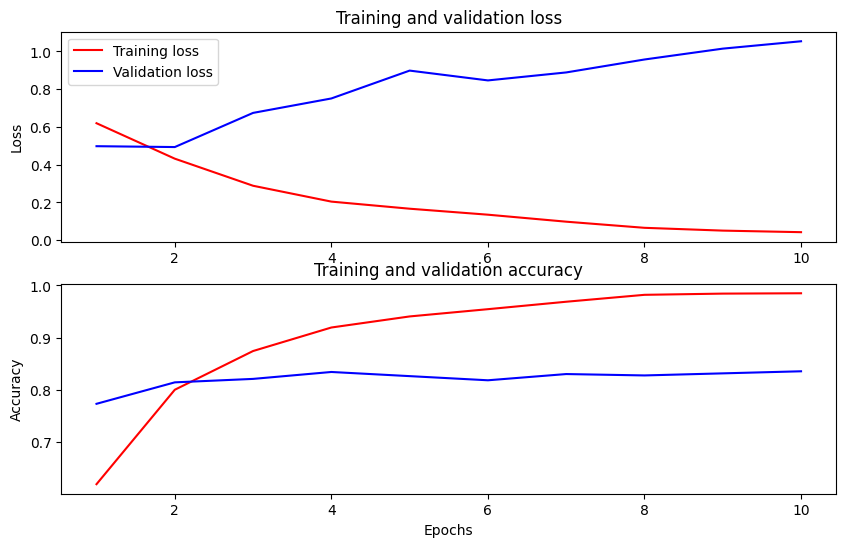

In [54]:
pnw_history_dict = pnw_history.history
print(pnw_history_dict.keys())

pnw_acc = pnw_history_dict['binary_accuracy']
pnw_val_acc = pnw_history_dict['val_binary_accuracy']
pnw_loss = pnw_history_dict['loss']
pnw_val_loss = pnw_history_dict['val_loss']

pnw_epochs = range(1, len(pnw_acc) + 1)
pnw_fig = plt.figure(figsize=(10, 6))
pnw_fig.tight_layout()

plt.subplot(2, 1, 1)

plt.plot(pnw_epochs, pnw_loss, 'r', label='Training loss')

plt.plot(pnw_epochs, pnw_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(pnw_epochs, pnw_acc, 'r', label='Training acc')
plt.plot(pnw_epochs, pnw_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

### Make Predictions

In [55]:
# pnw_eval_data = np.concatenate([atn_array(100), mnh_array(100)], 0)
pnw_df = pd.DataFrame(np.squeeze(pnw_classifier_model.predict(eval_data)), columns=['Pos & Neg Word List Model'])
pnw_df.insert(1, "Title", eval_data, True)
pnw_df

7/7 [==============================] - 3s 360ms/step


,Pos & Neg Word List Model,Title
0,6.182361,More Women in Their 60s and 70s Are Having ‘Wa...
1,6.602257,"Harvard Political Review: To Understand Trump,..."
2,0.051341,Justice Dept. Sues Michigan City After Mosque ...
3,8.983531,Introducing Myanmar’s ’Geek Girls’
4,7.216666,An Establishment Conservative’s Guide To The A...
...,...,...
195,-4.419916,phelps aiming to upstage thorpe
196,0.575116,kenbi mills
197,-6.560894,cracker of a cotton year
198,8.540446,hannay to make origin debut


### Compare predictions with the other models

In [56]:
overall_df.insert(0, "Pos & Neg Word List", pnw_df['Pos & Neg Word List Model'])
overall_df

,Pos & Neg Word List,IMDb Model,FPB Model,Title
0,6.182361,3.542113,-1.654533,More Women in Their 60s and 70s Are Having ‘Wa...
1,6.602257,2.438075,1.559295,"Harvard Political Review: To Understand Trump,..."
2,0.051341,-0.465708,-3.411098,Justice Dept. Sues Michigan City After Mosque ...
3,8.983531,3.762477,6.470010,Introducing Myanmar’s ’Geek Girls’
4,7.216666,3.165670,4.444001,An Establishment Conservative’s Guide To The A...
...,...,...,...,...
195,-4.419916,-3.276024,3.688459,phelps aiming to upstage thorpe
196,0.575116,2.782313,3.759456,kenbi mills
197,-6.560894,-0.555887,-7.483743,cracker of a cotton year
198,8.540446,-0.844037,6.614454,hannay to make origin debut


## Model IV - News Sentiment Dataset

### Downloading the Dataset

In [57]:
!cp "/content/drive/MyDrive/Colab Notebooks/Daily Sunshine App/data/news_sentiment_dataset.csv" "/content/news_sentiment_dataset.csv"

In [58]:
nsd_dataframe = pd.read_csv('news_sentiment_dataset.csv', encoding = 'utf-8', encoding_errors = 'ignore')
nsd_dataframe

,news_title,reddit_title,sentiment,text,url
0,Mark Cuban launches generic drug company,Billionaire Mark Cuban just launched a drug co...,1.0,Billionaire investor and Shark Tank star Mark ...,https://www.beckershospitalreview.com/pharmacy...
1,From Defendant to Defender: One Wrongfully Con...,"Man falsely imprisoned for 10 years, uses pris...",1.0,Attorney Jarrett Adams recently helped overtur...,https://www.nbcnews.com/news/us-news/defendant...
2,"Amazon Tribe Wins Lawsuit Against Big Oil, Sav...",Amazon tribe wins legal battle against oil com...,1.0,The Amazon Rainforest is well known across the...,https://www.disclose.tv/amazon-tribe-wins-laws...
3,Newark police: No officer fired a single shot ...,Newark police: No officer fired a single shot ...,1.0,Newark police: No officer fired a single shot ...,https://newjersey.news12.com/newark-police-no-...
4,Ingen barn døde i trafikken i 2019,No children died in traffic accidents in Norwa...,1.0,I 1970 døde det 560 mennesker i den norske tra...,https://www.nrk.no/trondelag/ingen-barn-dode-i...
...,...,...,...,...,...
843,Dee Why attack: Man allegedly choked and threa...,Dee Why attack: Man allegedly choked and threa...,0.0,Frightening details have emerged about a toile...,https://www.9news.com.au/2018/11/30/17/55/sydn...
844,Africa: Children and HIV/Aids - 'We Need to Ta...,Africa: Children and HIV/Aids - 'We Need to Ta...,0.0,"interview\n\nJohannesburg — 360,000 adolescent...",https://allafrica.com/stories/201811300567.html
845,Terrorism suspected in Eilat attack,Terrorism suspected in Eilat attack,0.0,A violent attack in the southern Israeli port ...,http://www.israelnationalnews.com/News/News.as...
846,Anti-Semitism never disappeared in Europe. It'...,Anti-Semitism never disappeared in Europe. It'...,0.0,"It's a 17-year-old boy, too frightened to wear...",https://edition.cnn.com/2018/11/27/europe/anti...


### Split the data into Training, Testing and Validation Datasets

In [65]:
!rm -rf news_sentiment_dataset

In [66]:
nsd_dataset_dir = 'news_sentiment_dataset'

os.mkdir(nsd_dataset_dir)

nsd_train_dir = os.path.join(nsd_dataset_dir, 'train')
nsd_test_dir = os.path.join(nsd_dataset_dir, 'test')

os.mkdir(nsd_train_dir)
os.mkdir(nsd_test_dir)

for path in [nsd_train_dir, nsd_test_dir]:
  os.mkdir(os.path.join(path, 'negative'))
  os.mkdir(os.path.join(path, 'positive'))


count_train = 1
count_test = 1

# Training Dataset
for ind in nsd_dataframe[int(.6*len(nsd_dataframe)):].index:
  with open(os.path.join(nsd_train_dir, 'negative' if nsd_dataframe['sentiment'][ind] == 0 else 'positive', str(count_train)+'.txt'), 'w') as file_obj:
    file_obj.write(nsd_dataframe['news_title'][ind])
  count_train +=1

# Testing Dataset
for ind in nsd_dataframe[:int(.3*len(nsd_dataframe))].index:
  with open(os.path.join(nsd_test_dir, 'negative' if nsd_dataframe['sentiment'][ind] == 0 else 'positive', str(count_test)+'.txt'), 'w') as file_obj:
    file_obj.write(nsd_dataframe['news_title'][ind])
  count_test +=1

### Preprocess Data

In [67]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

nsd_raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    nsd_train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

nsd_class_names = nsd_raw_train_ds.class_names
nsd_train_ds = nsd_raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

nsd_val_ds = tf.keras.utils.text_dataset_from_directory(
    nsd_train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

nsd_val_ds = nsd_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

nsd_test_ds = tf.keras.utils.text_dataset_from_directory(
    nsd_test_dir,
    batch_size=batch_size)

nsd_test_ds = nsd_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 340 files belonging to 2 classes.
Using 272 files for training.
Found 340 files belonging to 2 classes.
Using 68 files for validation.
Found 254 files belonging to 2 classes.


### Selecting a BERT Model

In [68]:
#@title Choose a BERT model to fine-tune for Positive and Negative Word List Model

nsd_bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]


nsd_tfhub_handle_encoder = map_name_to_handle[nsd_bert_model_name]
nsd_tfhub_handle_preprocess = map_model_to_preprocess[nsd_bert_model_name]

print(f'BERT model selected           : {nsd_tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {nsd_tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [69]:
nsd_bert_preprocess_model = hub.KerasLayer(nsd_tfhub_handle_preprocess)

In [70]:
nsd_bert_model = hub.KerasLayer(nsd_tfhub_handle_encoder)

### Using the BERT Model

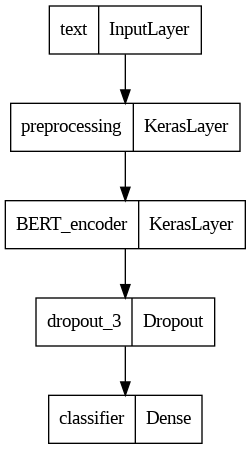

In [71]:
nsd_classifier_model = build_classifier_model(nsd_tfhub_handle_preprocess, nsd_tfhub_handle_encoder)
tf.keras.utils.plot_model(nsd_classifier_model)

In [72]:
nsd_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
nsd_metrics = tf.metrics.BinaryAccuracy()

nsd_epochs = 10
nsd_steps_per_epoch = tf.data.experimental.cardinality(nsd_train_ds).numpy()
nsd_num_train_steps = nsd_steps_per_epoch * nsd_epochs
nsd_num_warmup_steps = int(0.1*nsd_num_train_steps)

nsd_init_lr = 3e-5
nsd_optimizer = optimization.create_optimizer(init_lr=nsd_init_lr,
                                          num_train_steps=nsd_num_train_steps,
                                          num_warmup_steps=nsd_num_warmup_steps,
                                          optimizer_type='adamw')

In [73]:
nsd_classifier_model.compile(optimizer=nsd_optimizer,
                         loss=nsd_loss,
                         metrics=nsd_metrics)

nsd_history = nsd_classifier_model.fit(x=nsd_train_ds,
                               validation_data=nsd_val_ds,
                               epochs=nsd_epochs)

Epoch 1/10
9/9 [==============================] - 11s 522ms/step - loss: 0.7415 - binary_accuracy: 0.4007 - val_loss: 0.5502 - val_binary_accuracy: 0.7500
Epoch 2/10
9/9 [==============================] - 3s 318ms/step - loss: 0.6048 - binary_accuracy: 0.7243 - val_loss: 0.4938 - val_binary_accuracy: 0.8088
Epoch 3/10
9/9 [==============================] - 2s 219ms/step - loss: 0.4805 - binary_accuracy: 0.7721 - val_loss: 0.4474 - val_binary_accuracy: 0.8088
Epoch 4/10
9/9 [==============================] - 2s 221ms/step - loss: 0.4019 - binary_accuracy: 0.8640 - val_loss: 0.4174 - val_binary_accuracy: 0.8088
Epoch 5/10
9/9 [==============================] - 2s 222ms/step - loss: 0.3610 - binary_accuracy: 0.8713 - val_loss: 0.3857 - val_binary_accuracy: 0.8088
Epoch 6/10
9/9 [==============================] - 2s 220ms/step - loss: 0.2936 - binary_accuracy: 0.8971 - val_loss: 0.3792 - val_binary_accuracy: 0.8088
Epoch 7/10
9/9 [==============================] - 2s 282ms/step - loss: 0.2

### Evaluating the Model

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


Text(0, 0.5, 'Accuracy')

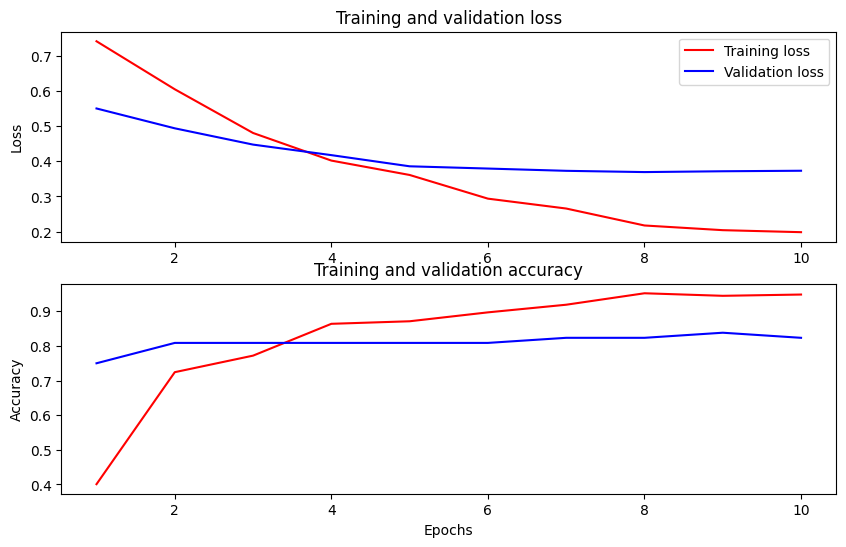

In [74]:
nsd_history_dict = nsd_history.history
print(nsd_history_dict.keys())

nsd_acc = nsd_history_dict['binary_accuracy']
nsd_val_acc = nsd_history_dict['val_binary_accuracy']
nsd_loss = nsd_history_dict['loss']
nsd_val_loss = nsd_history_dict['val_loss']

nsd_epochs = range(1, len(nsd_acc) + 1)
nsd_fig = plt.figure(figsize=(10, 6))
nsd_fig.tight_layout()

plt.subplot(2, 1, 1)

plt.plot(nsd_epochs, nsd_loss, 'r', label='Training loss')

plt.plot(nsd_epochs, nsd_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(nsd_epochs, nsd_acc, 'r', label='Training acc')
plt.plot(nsd_epochs, nsd_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

### Make Predictions

In [75]:
# nsd_eval_data = np.concatenate([atn_array(100), mnh_array(100)], 0)
nsd_df = pd.DataFrame(np.squeeze(nsd_classifier_model.predict(eval_data)), columns=['News Sentiment Dataset Model'])
nsd_df.insert(1, "Title", eval_data, True)
nsd_df

7/7 [==============================] - 1s 85ms/step


,News Sentiment Dataset Model,Title
0,0.123268,More Women in Their 60s and 70s Are Having ‘Wa...
1,-0.387179,"Harvard Political Review: To Understand Trump,..."
2,2.229828,Justice Dept. Sues Michigan City After Mosque ...
3,1.560382,Introducing Myanmar’s ’Geek Girls’
4,1.023739,An Establishment Conservative’s Guide To The A...
...,...,...
195,1.696876,phelps aiming to upstage thorpe
196,0.694283,kenbi mills
197,0.046458,cracker of a cotton year
198,2.679347,hannay to make origin debut


### Compare predictions with the other models

In [76]:
overall_df.insert(0, "News Sentiment Dataset Model", nsd_df['News Sentiment Dataset Model'])
overall_df

,News Sentiment Dataset Model,Pos & Neg Word List,IMDb Model,FPB Model,Title
0,0.123268,6.182361,3.542113,-1.654533,More Women in Their 60s and 70s Are Having ‘Wa...
1,-0.387179,6.602257,2.438075,1.559295,"Harvard Political Review: To Understand Trump,..."
2,2.229828,0.051341,-0.465708,-3.411098,Justice Dept. Sues Michigan City After Mosque ...
3,1.560382,8.983531,3.762477,6.470010,Introducing Myanmar’s ’Geek Girls’
4,1.023739,7.216666,3.165670,4.444001,An Establishment Conservative’s Guide To The A...
...,...,...,...,...,...
195,1.696876,-4.419916,-3.276024,3.688459,phelps aiming to upstage thorpe
196,0.694283,0.575116,2.782313,3.759456,kenbi mills
197,0.046458,-6.560894,-0.555887,-7.483743,cracker of a cotton year
198,2.679347,8.540446,-0.844037,6.614454,hannay to make origin debut
